### Setting up variables

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [ ]:
demographics = pd.read_csv('/content/MOGDatabase-Demographics_DATA_2025-04-05_1612.csv')
attacks = pd.read_csv('/content/MOGDatabase-ClinicalAttacks_DATA_2025-04-02_1544.csv')
incident = pd.read_csv('/content/MOGDatabase-IncidentCriteriaCoho_DATA_2025-04-02_1550.csv')

# Clean demographics
demos_to_drop = [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 46, 48, 49, 50, 51, 52, 53, 59, 60, 61, 62]
demos_to_keep = [i for i in range(demographics.shape[1]) if i not in demos_to_drop]
demos_clean = demographics.iloc[:, demos_to_keep]
#demos_clean.head()

# Add clinical presentation of first attack into demographics
first_attacks = attacks.groupby(['record_id']).nth(1).reset_index()
filtered_demos = demos_clean[demos_clean['record_id'].isin(first_attacks['record_id'])]

first_attack_presentation = first_attacks.iloc[:, 5:49]
first_attack_presentation.index = first_attacks['record_id']

first_ONseverity = pd.DataFrame(first_attacks.iloc[:, 14:19].sum(axis=1)).rename(columns={0: 'ONseverity'})
first_Mseverity = pd.DataFrame(first_attacks.iloc[:, 19:23].sum(axis=1)).rename(columns={0: 'Mseverity'})
first_Bseverity = pd.DataFrame(first_attacks.iloc[:, 19:28].sum(axis=1)).rename(columns={0: 'Bseverity'})

first_ONseverity.index = first_attacks['record_id']
first_Mseverity.index = first_attacks['record_id']
first_Bseverity.index = first_attacks['record_id']

demo_clinical1 = filtered_demos.join(first_attack_presentation, on='record_id')
demo_clinical2 = demo_clinical1.join(first_ONseverity, on='record_id')
demo_clinical3 = demo_clinical2.join(first_Mseverity, on='record_id')
demo_clinical = demo_clinical3.join(first_Bseverity, on='record_id')

#demo_clinical.head()

# Count occurrences of each number
counts = attacks['record_id'].value_counts()

# Get numbers that appear exactly 2 times
appears_twice = counts[counts == 2].index.tolist()

# Get numbers that appear more than 2 times
appears_more_than_twice = counts[counts > 2].index.tolist()

# Display results
# print("Numbers that appear exactly twice:", appears_twice)
# print("Numbers that appear more than twice:", appears_more_than_twice)

demo_clinical['relapse'] = np.where(
    demo_clinical['record_id'].isin(appears_twice), 0,
    np.where(demo_clinical['record_id'].isin(appears_more_than_twice), 1, None)
)

first_ONseverity.head()


,ONseverity
record_id,
12,4.0
13,0.0
14,0.0
15,0.0
16,4.0


In [ ]:
# Remove incident cohort
# incident_list = incident['record_id'].unique().tolist()
# halfway = int(len(incident_list)/2)
# val_list = incident_list[:halfway]
# test_list = incident_list[halfway:]

# train_dataset = demo_clinical[~demo_clinical['record_id'].isin(incident_list)]

# val_dataset = demo_clinical[demo_clinical['record_id'].isin(val_list)]
# test_dataset = demo_clinical[demo_clinical['record_id'].isin(test_list)]


In [ ]:
# Combined with incident cohort, remove random 15% for val and test

#previous random_state = 42

val_dataset = demo_clinical.sample(frac=0.15, random_state=100)

train_dataset_temp = demo_clinical.drop(val_dataset.index)

test_dataset = train_dataset_temp.sample(frac=0.15, random_state=100)

train_dataset = train_dataset_temp.drop(test_dataset.index)

### Logistic regression

In [ ]:
import random
from matplotlib import pyplot as plt
last_col = 82

X_train = pd.concat([train_dataset.iloc[:, 1:last_col], val_dataset.iloc[:, 1:last_col]], ignore_index=True).fillna(0)
Y_train = pd.concat([train_dataset.iloc[:, last_col], val_dataset.iloc[:, last_col]], ignore_index=True).fillna(0)

X_test = test_dataset.iloc[:, 1:last_col].fillna(0)
Y_test = test_dataset.iloc[:, last_col].fillna(0)
X_test.head()

<ipython-input-25-49b52f3d9b9a>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = pd.concat([train_dataset.iloc[:, last_col], val_dataset.iloc[:, last_col]], ignore_index=True).fillna(0)
<ipython-input-25-49b52f3d9b9a>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = test_dataset.iloc[:, last_col].fillna(0)


,age,sex,race,ethnicity,weight_kg,height_cm,bmi_calculated,any_major_comorbidities_pr___1,any_major_comorbidities_pr___2,any_major_comorbidities_pr___3,...,clinical_symptoms___13,clinical_symptoms___14,clinical_symptoms___15,clinical_symptoms___16,clinical_symptoms___17,clinical_symptoms___18,clinical_symptoms___19,ONseverity,Mseverity,Bseverity
50,49,2,5.0,2.0,62.1,160.0,24.3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
149,58,1,1.0,2.0,77.1,177.8,24.4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
230,36,1,1.0,2.0,0.0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
181,47,2,1.0,2.0,88.5,162.6,33.5,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,26,2,1.0,2.0,64.4,157.5,26.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [ ]:
from sklearn import metrics
import numpy as np
lr_model = LogisticRegression(penalty=None)

lr_model.fit(X_train, Y_train);

print(f'beta = {lr_model.coef_}')
print(f'epsilon = {lr_model.intercept_}')

beta = [[-2.58560579e-02  2.88495384e-01 -5.59487990e-02  8.67123622e-01
   5.42144186e-02 -4.66026138e-03 -1.41747963e-01  3.48814839e-02
   1.84557841e-01 -3.20373737e-01  2.07565594e-01  4.27570693e-01
   6.93273212e-01 -3.56591789e-01 -2.93578616e-01  3.72847594e-01
  -1.35894700e-01  2.65838276e-01  0.00000000e+00  1.93296738e-01
  -2.90398703e-01  7.23317096e-02  8.78424920e-02 -3.85118253e-02
   1.57299737e-01  0.00000000e+00  1.93120493e-01  2.08634864e-01
   1.87262960e-01 -2.07651024e-01 -4.91366361e-02  9.13075368e-01
   4.17019638e-01 -9.19457801e-01  1.23111163e-01  1.41329516e-01
   1.50856815e-02  5.95548835e-02 -3.70088871e-01  6.31891865e-01
   4.49544963e-01 -2.33291709e-01  5.36564411e-02  2.88424518e-01
   2.66478038e-01 -1.95652944e-01 -1.72634327e-01 -4.73693703e-01
   2.85984630e-01  1.91354110e-01 -6.35441464e-01 -2.59837319e-01
  -2.91513051e-01  3.32269757e-01  8.04641022e-02 -1.10050586e-01
   3.21785488e-01  3.54824831e-01  1.10065063e-01 -4.47572237e-02
  -

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Create a DataFrame to pair feature names with coefficients

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': np.array(lr_model.coef_).flatten()
})


# Sort by magnitude of coefficient
coef_df_sorted = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
  print(coef_df_sorted)

                           Feature  Coefficient
33              diagnosis_defin_v2    -0.919458
31      history_of_significant_alc     0.913075
3                        ethnicity     0.867124
12  any_major_comorbidities_pr___6     0.693273
50  myelitis_supporting_criter___2    -0.635441
39        relapse_presentation___3     0.631892
47      on_supporting_criteria___4    -0.473694
40        relapse_presentation___4     0.449545
11  any_major_comorbidities_pr___5     0.427571
79                       Mseverity    -0.417940
32               seizures_baseline     0.417020
15  any_history_of_pregnancies___2     0.372848
38        relapse_presentation___2    -0.370089
13  any_major_comorbidities_pr___7    -0.356592
57   brain_supporting_criteria___5     0.354825
53   brain_supporting_criteria___1     0.332270
56   brain_supporting_criteria___4     0.321785
9   any_major_comorbidities_pr___3    -0.320374
14  any_history_of_pregnancies___1    -0.293579
52  myelitis_supporting_criter___4    -0

In [ ]:
est = lr_model.predict_proba(X_test)[:,1]

AUROC: 0.56
AUPRC: 0.696417595788178
Sensitivity: 0.6666666666666666
Specificity: 0.38461538461538464
PPV: 0.6363636363636364
NPV: 0.4166666666666667


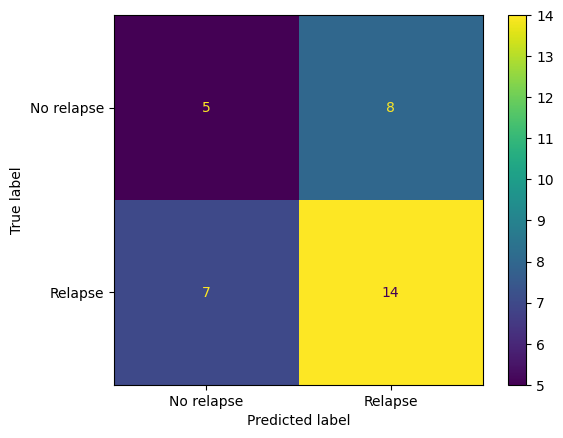

In [ ]:
# Compute performance metrics
from sklearn.metrics import roc_auc_score

AUROC_relapse = roc_auc_score(Y_test, est)
print(f'AUROC: {AUROC_relapse:.2f}')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(Y_test, est)
area = auc(recall, precision)
print("AUPRC: " + str(area))

threshold = 0.5
est_binary = est > threshold

CM = confusion_matrix(Y_test, est_binary)

tn, fp, fn, tp = CM.ravel()

cm_display = ConfusionMatrixDisplay(CM, display_labels=['No relapse', 'Relapse'])
cm_display.plot();

sens = tp/(tp+fn)
print("Sensitivity: " + str(sens))
spec = tn/(tn+fp)
print("Specificity: " + str(spec))
ppv = tp/(tp+fp)
print("PPV: " + str(ppv))
npv = tn/(tn+fn)
print("NPV: " + str(npv))


#### Analyzing LR results


In [ ]:
crit1 = demo_clinical[demo_clinical["history_of_significant_alc"] == 1]
percent_relapse_crit1 = (crit1["relapse"] == 1).mean() * 100

print(f"{percent_relapse_crit1:.2f}% of patients with history of alcohol use had a relapse.")

crit2 = demo_clinical[demo_clinical["diagnosis_defin_v2"] == 1]
percent_relapse_crit2 = (crit2["relapse"] == 1).mean() * 100

print(f"{percent_relapse_crit2:.2f}% of patients with a definitive diagnosis (clinician judgement) of MOG had a relapse.")

58.30% of patients with history of alcohol use had a relapse.
60.09% of patients with a definitive diagnosis (clinician judgement) of MOG had a relapse.


### RFC

In [ ]:
### RFC

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=50,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42
)

X_train = train_dataset.iloc[:, 1:last_col].fillna(0)
Y_train = train_dataset.iloc[:, last_col].fillna(0)

X_val = val_dataset.iloc[:, 1:last_col].fillna(0)
Y_val = val_dataset.iloc[:, last_col].fillna(0)

X_test = test_dataset.iloc[:, 1:last_col].fillna(0)
Y_test = test_dataset.iloc[:, last_col].fillna(0)

rfc.fit(X_train, Y_train)

# Make predictions
y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)[:, 1]  # For AUROC

# Evaluate
print(classification_report(Y_test, y_pred))
print("AUROC:", roc_auc_score(Y_test, y_prob))

In [ ]:
importances = rfc.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances')
plt.show()

In [ ]:
# Compute performance metrics
from sklearn.metrics import roc_auc_score

AUROC_relapse = roc_auc_score(Y_test, y_prob)
print(f'AUROC: {AUROC_relapse:.2f}')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(Y_test, y_prob)
area = auc(recall, precision)
print("AUPRC: " + str(area))


CM = confusion_matrix(Y_test, y_pred)

tn, fp, fn, tp = CM.ravel() # ravel turns a matrix into a 1D array

cm_display = ConfusionMatrixDisplay(CM, display_labels=['No relapse', 'Relapse'])
cm_display.plot();

sens = tp/(tp+fn)
print("Sensitivity: " + str(sens))
spec = tn/(tn+fp)
print("Specificity: " + str(spec))
ppv = tp/(tp+fp)
print("PPV: " + str(ppv))
npv = tn/(tn+fn)
print("NPV: " + str(npv))

### NN attempt 1

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [ ]:
class SampleDataset(Dataset) :
  # constructor method
  def __init__(self, X, y) :
    self.X = X
    self.y = y

  # method to retrieve the length of the dataset
  def __len__(self) :
    return len(self.X)

  # method to retrieve an entry at a given index
  def __getitem__(self, idx) :
    return self.X[idx], self.y[idx]

In [ ]:
X_train = train_dataset.iloc[:, 1:last_col].fillna(0)
Y_train = train_dataset.iloc[:, last_col].fillna(0)

X_val = val_dataset.iloc[:, 1:last_col].fillna(0)
Y_val = val_dataset.iloc[:, last_col].fillna(0)

X_test = test_dataset.iloc[:, 1:last_col].fillna(0)
Y_test = test_dataset.iloc[:, last_col].fillna(0)

training_dataset = SampleDataset(torch.Tensor(X_train.values),
                                 torch.Tensor(Y_train.values).unsqueeze(1))
validation_dataset = SampleDataset(torch.Tensor(X_val.values),
                                 torch.Tensor(Y_val.values).unsqueeze(1))


# ## trying feature reduction

# from sklearn.feature_selection import SelectKBest, f_classif

# selector = SelectKBest(score_func=f_classif, k=40)  # Select top 20 features


# X_train_selected = selector.fit_transform(X_train, Y_train)
# X_val_selected = selector.fit_transform(X_val, Y_val)
# X_test_selected = selector.fit_transform(X_test, Y_test)

# selected_features = X_train.columns[selector.get_support()]
# print(selected_features)

# training_dataset = SampleDataset(torch.Tensor(X_train_selected),
#                                  torch.Tensor(Y_train.values).unsqueeze(1))
# validation_dataset = SampleDataset(torch.Tensor(X_val_selected),
#                                  torch.Tensor(Y_val.values).unsqueeze(1))

<ipython-input-198-5cbf6f8d0663>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = train_dataset.iloc[:, last_col].fillna(0)
<ipython-input-198-5cbf6f8d0663>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_val = val_dataset.iloc[:, last_col].fillna(0)
<ipython-input-198-5cbf6f8d0663>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tru

In [ ]:
# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Xtrain_scaled = X_train.copy()

Xval_scaled = X_val.copy()

Xtest_scaled = X_test.copy()

Xtrain_scaled[X_train.columns] = scaler.fit_transform(X_train)
Xval_scaled[X_val.columns] = scaler.fit_transform(X_val)
Xtest_scaled[X_test.columns] = scaler.fit_transform(X_test)


training_dataset = SampleDataset(torch.Tensor(Xtrain_scaled.values),
                                 torch.Tensor(Y_train.values).unsqueeze(1))
validation_dataset = SampleDataset(torch.Tensor(Xval_scaled.values),
                                 torch.Tensor(Y_val.values).unsqueeze(1))



In [ ]:
class DropoutModel(nn.Module) :
  # constructor
  # for layers, note that first element must equal the input size
  def __init__(self, layers=[2], output_size=1, activation_fn = F.relu,
               dropout_rate=0.5) :
    super().__init__()

    self.activation_fn = activation_fn
    self.dropout_rate = dropout_rate

    hidden_layer_list = []
    dropout_layer_list = []
    for i in range(len(layers)-1) :
      in_shape = layers[i]
      out_shape = layers[i+1]
      hidden_layer_list.append(nn.Linear(in_shape, out_shape))
      dropout_layer_list.append(nn.Dropout(p=self.dropout_rate))

    self.hidden_layer_list = nn.ModuleList(hidden_layer_list)
    self.dropout_layer_list = nn.ModuleList(dropout_layer_list)
    self.last_layer = nn.Linear(layers[-1], output_size)

  def forward(self, x) :

    for layer, dropout in zip(self.hidden_layer_list, self.dropout_layer_list) :

      x = self.activation_fn(layer(x))
      x = dropout(x)

    y = self.last_layer(x)

    return y

In [ ]:
class GeneralModel(nn.Module) :
  def __init__(self, layers=[34], output_size=1, activation_fn = F.relu) :
    super().__init__()

    self.activation_fn = activation_fn

    hidden_layer_list = []
    for i in range(len(layers)-1) :
      in_shape = layers[i]
      out_shape = layers[i+1]
      hidden_layer_list.append(nn.Linear(in_shape, out_shape))

    self.hidden_layer_list = nn.ModuleList(hidden_layer_list)
    self.last_layer = nn.Linear(layers[-1], output_size)

  def forward(self, x) :

    for layer in self.hidden_layer_list :
      x = self.activation_fn(layer(x))

    y = self.last_layer(x)

    return y

In [ ]:
# training loop
import copy

pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()  # inverse ratio pos_weight=torch.tensor(pos_weight)

def training_loop_with_val(model,
                           training_dataset,
                           validation_dataset,
                           batch_size = 8,
                           learning_rate= 1e-4,
                           num_epochs= 100,
                           loss_fn=nn.MSELoss()) :

  train_dataloader = DataLoader(training_dataset,
                                batch_size=8,
                                shuffle=True)

  # instantiate the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  # keep track of the loss per epoch
  track_loss = []
  track_val_loss = []

  # iterate through epochs

  n_batches = len(training_dataset)/batch_size


  best_weights = []
  best_loss = 1e9
  best_epoch = 0

  for epoch in tqdm(range(num_epochs)) :
    model.train()
    # track the total loss within each epoch
    track_total_epoch_loss = 0
    # iterate over the dataset
    for idx, sample in enumerate(train_dataloader) :
      # zero optimizer gradients
      optimizer.zero_grad()
      # retrieve the input and label
      X_samp = sample[0]
      y_samp = sample[1]

      # apply the model to the input data
      y_est = model(X_samp)

      # compute the loss
      loss_value = loss_fn(y_est, y_samp)

      # compute gradients
      loss_value.backward()

      # adjust the model weights
      optimizer.step()

    model.eval()
    y_all_est = model(training_dataset.X)
    loss_value = loss_fn(y_all_est, training_dataset.y)

    track_loss.append(loss_value.detach().item())


    # compute performance on validation data
    y_est_val = model(validation_dataset.X)
    loss_value = loss_fn(y_est_val, validation_dataset.y)
    track_val_loss.append(loss_value.detach().item())

    if loss_value < best_loss :
      best_loss = loss_value
      best_weights = copy.deepcopy(model.state_dict())
      best_epoch = epoch


  model.load_state_dict(best_weights)
  print(f'Best Epoch: {best_epoch}')
  return model, track_loss, track_val_loss

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.eye_(m.weight)
        m.bias.data.fill_(0.01)

model.train()
model = DropoutModel(layers=[81, 160, 64, 8], dropout_rate = 0.2)
model.apply(init_weights)

DropoutModel(
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=81, out_features=160, bias=True)
    (1): Linear(in_features=160, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
  (dropout_layer_list): ModuleList(
    (0-2): 3 x Dropout(p=0.2, inplace=False)
  )
  (last_layer): Linear(in_features=8, out_features=1, bias=True)
)

  0%|          | 0/100 [00:00<?, ?it/s]

Best Epoch: 41
MAE for training set: 0.3805646061973304
MAE for test set: 0.5336372282575158
MAE for validation set: 0.5479287981260114


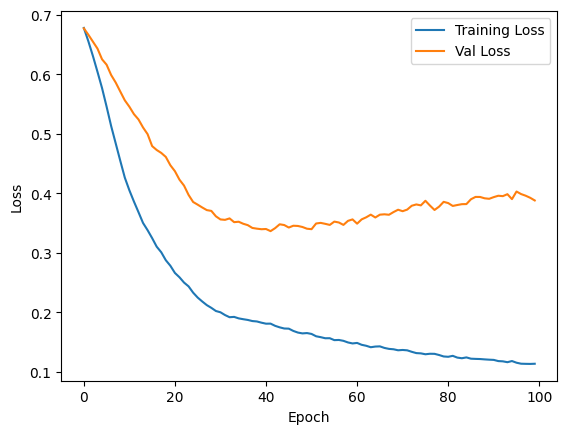

In [ ]:
model_result, track_loss_result, track_val_loss_result = training_loop_with_val(model, training_dataset, validation_dataset)

plt.plot(track_loss_result, label = 'Training Loss')
plt.plot(track_val_loss_result, label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#MAE training
# X_train_tensor = torch.Tensor(X_train_selected)
# X_test_tensor = torch.Tensor(X_test_selected)
# X_val_tensor = torch.Tensor(X_val_selected)


X_train_tensor = torch.Tensor(Xtrain_scaled.values)
X_test_tensor = torch.Tensor(Xtest_scaled.values)
X_val_tensor = torch.Tensor(Xval_scaled.values)

y_train_est = model_result(X_train_tensor)
y_train_est_np = y_train_est.detach().numpy().squeeze()

y_test_est = model_result(X_test_tensor)
y_test_est_np = y_test_est.detach().numpy().squeeze()

y_val_est = model_result(X_val_tensor)
y_val_est_np = y_val_est.detach().numpy().squeeze()

mae = np.mean(np.abs(Y_train - y_train_est_np))
print(f'MAE for training set: {mae}')

mae = np.mean(np.abs(Y_test - y_test_est_np))
print(f'MAE for test set: {mae}')

mae = np.mean(np.abs(Y_val - y_val_est_np))
print(f'MAE for validation set: {mae}')

AUROC: 0.454
AUPRC: 0.5635050539955158


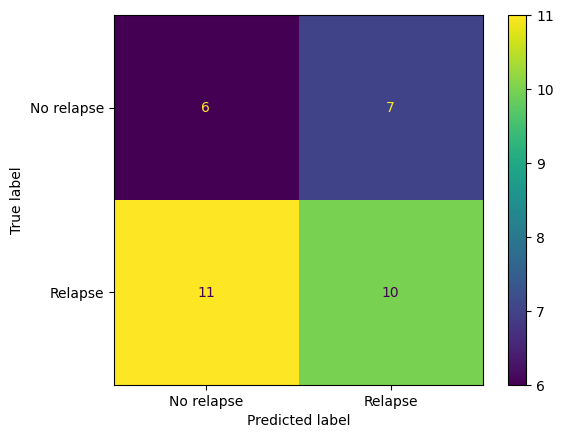

In [ ]:
auc_small_model = roc_auc_score(Y_test, y_test_est_np)
print(f'AUROC: {auc_small_model:.3f}')

precision, recall, thresholds = precision_recall_curve(Y_test, y_test_est_np)
area = auc(recall, precision)
print("AUPRC: " + str(area))

est_binary = y_test_est > 0.5
CM = confusion_matrix(Y_test, est_binary)
tn, fp, fn, tp = CM.ravel()
cm_display = ConfusionMatrixDisplay(CM, display_labels=['No relapse', 'Relapse'])
cm_display.plot();


Threshold: 0.1
Sensitivity: 0.8571428571428571
Specificity: 0.07692307692307693
PPV: 0.6
NPV: 0.25
Accuracy: 0.5588235294117647


Threshold: 0.2
Sensitivity: 0.8571428571428571
Specificity: 0.07692307692307693
PPV: 0.6
NPV: 0.25
Accuracy: 0.5588235294117647


Threshold: 0.3
Sensitivity: 0.6666666666666666
Specificity: 0.3076923076923077
PPV: 0.6086956521739131
NPV: 0.36363636363636365
Accuracy: 0.5294117647058824


Threshold: 0.4
Sensitivity: 0.6666666666666666
Specificity: 0.3076923076923077
PPV: 0.6086956521739131
NPV: 0.36363636363636365
Accuracy: 0.5294117647058824


Threshold: 0.5
Sensitivity: 0.5714285714285714
Specificity: 0.46153846153846156
PPV: 0.631578947368421
NPV: 0.4
Accuracy: 0.5294117647058824


Threshold: 0.6
Sensitivity: 0.42857142857142855
Specificity: 0.5384615384615384
PPV: 0.6
NPV: 0.3684210526315789
Accuracy: 0.47058823529411764


Threshold: 0.7
Sensitivity: 0.38095238095238093
Specificity: 0.6923076923076923
PPV: 0.6666666666666666
NPV: 0.4090909090909091
Accur

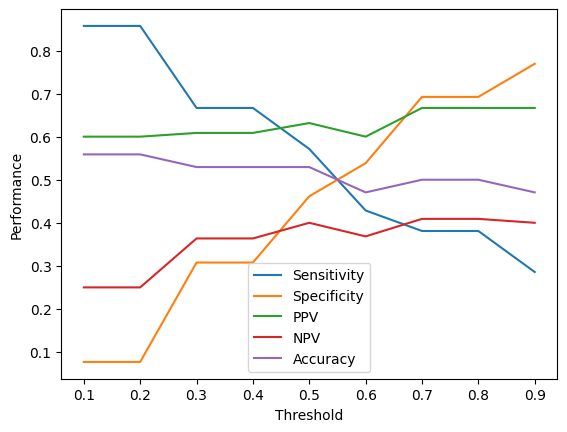

In [ ]:
# finding the best threshold
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sens_list = []
spec_list = []
ppv_list = []
npv_list = []
accuracy_list = []

for i in threshold_list:
  est_binary = y_test_est > i
  CM = confusion_matrix(Y_test, est_binary)
  tn, fp, fn, tp = CM.ravel()
  print("")
  print("Threshold: " + str(i))
  sens = tp/(tp+fn)
  print("Sensitivity: " + str(sens))
  spec = tn/(tn+fp)
  print("Specificity: " + str(spec))
  ppv = tp/(tp+fp)
  print("PPV: " + str(ppv))
  npv = tn/(tn+fn)
  print("NPV: " + str(npv))
  accuracy = (tp+tn)/(tp+tn+fn+fp)
  print("Accuracy: " + str(accuracy))
  print("")
  sens_list.append(sens)
  spec_list.append(spec)
  ppv_list.append(ppv)
  npv_list.append(npv)
  accuracy_list.append(accuracy)

plt.plot(threshold_list, sens_list)
plt.plot(threshold_list, spec_list)
plt.plot(threshold_list, ppv_list)
plt.plot(threshold_list, npv_list)
plt.plot(threshold_list, accuracy_list)
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.legend(['Sensitivity', 'Specificity', 'PPV', 'NPV', 'Accuracy'])
plt.show()
